In [3]:
import requests
import numpy as np
from config import *
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc

#### 1. 5월 각 날짜 별로 경제 분야 전체 뉴스 기사 갯수 카운트하고 출력

In [4]:
def daily_news():
    url = f"{ELASTIC_SEARCH_URL}/news/_search"

    query_day = """
    {
    "size": 0,
    "aggs": {
        "group_by_date":{
        "date_histogram": {
            "field": "created_at",
            "interval": "day"
        }
        }
    }
    }
    """

    headers = {
        'Content-Type' : 'application/json'
    }

    resp = requests.get(
        url,
        data=query_day,
        headers=headers,
        auth= ELASTIC_SEARCH_AUTH
    )

    data = resp.json()

    daily = data['aggregations']['group_by_date']['buckets']

    df_daily = pd.DataFrame(data = daily)

    df_daily['date'] = pd.to_datetime(df_daily['key_as_string'])

    df_daily = df_daily.set_index('date')
    
    df_daily = df_daily['2022-05-01':'2022-05-31']

    plt.figure(figsize=(10,6))
    plt.plot(df_daily['doc_count'], label = 'Daily News')
    plt.legend()
    plt.xticks(rotation = 30)
    plt.xlabel('Date')
    plt.ylabel('Number of News')
    plt.show()
    return df_daily
    

#### 뉴스 기사 가장 많은 탑 5 언론사 선정해서 리스트로 반환

In [5]:
def top_publisher():
    url = f"{ELASTIC_SEARCH_URL}/news/_search"

    query_publisher = """
    {
    "size": 0,
    "aggs": {
        "group_by_publisher":{
        "terms": {
            "field": "publisher.keyword"
        }
        }
    }
    }
    """

    headers = {
        'Content-Type' : 'application/json'
    }

    resp = requests.get(
        url,
        data=query_publisher,
        headers=headers,
        auth= ELASTIC_SEARCH_AUTH
    )

    data = resp.json()

    dict = data['aggregations']['group_by_publisher']['buckets'][1:6]

    publisher_list = []
    for i in range(len(dict)):
        publisher_list.append(dict[i]['key'])

    return publisher_list

#### 2. Top5 언론사 리스트 변수로 받아 각 날짜 별로 언론사 기사 갯수 time-series chart 출력

In [6]:
def news_trends_by_publisher(publisher_list):
    url = f"{ELASTIC_SEARCH_URL}/news/_search"
    
    df_publisher = pd.DataFrame()

    for pub in publisher_list:
        query = """
            {
                "size": 0,
                "aggs": {
                    "group_by_publisher":{
                        "terms":{
                            "field":"publisher.keyword",
                            "include": "%s"
                        },
                        "aggs": {
                            "group_by_date":{
                                "date_histogram": {
                                    "field": "created_at",
                                    "interval": "day"
                                }
                            }
                        }       
                    }
                }
            }
        """ %str(pub)
        headers = {
        'Content-Type' : 'application/json'
        }

        resp = requests.get(
            url,
            data=query.encode('utf-8'),
            headers=headers,
            auth= ELASTIC_SEARCH_AUTH
        )

        data = resp.json()

        publisher_daily = data['aggregations']['group_by_publisher']['buckets'][0]['group_by_date']['buckets']
        df_temp = pd.DataFrame(data = publisher_daily)
        df_temp['date'] = pd.to_datetime(df_temp['key_as_string'])
        df_temp = df_temp.set_index('date')
        df_temp = df_temp['2022-05-01':'2022-05-31']
        df_publisher[pub] = df_temp['doc_count']

    plt.figure(figsize=(15,9))
    plt.plot(df_publisher.iloc[:,[0]], label = 'News1')
    plt.plot(df_publisher.iloc[:,[1]], label = 'Newsis')
    plt.plot(df_publisher.iloc[:,[2]], label = 'E-daily')
    plt.plot(df_publisher.iloc[:,[3]], label = 'Financial news')
    plt.plot(df_publisher.iloc[:,[4]], label = 'Money Today')
    plt.legend(loc = 'upper left')
    plt.xlabel('Date')
    plt.ylabel('Number of News')
    plt.xticks(rotation = 30)
    plt.show()
    
    return df_publisher



#### 3. 키워드 리스트를 변수로 받아 키워드별 일별 기사 갯수 & 비율 출력

In [7]:
def news_trends_by_keyword(keyword_list, df_daily):
    url = f"{ELASTIC_SEARCH_URL}/news/_search"
    
    df_keyword = pd.DataFrame()
    df_ratio = pd.DataFrame()

    for keyword in keyword_list:
        query = """
            {
                "size": 0,
                "aggs": {
                    "group_by_date":{
                        "date_histogram": {
                            "field": "created_at",
                            "interval": "day"
                        }
                    }
                },
                "query":{
                    "match":{
                    "body": "%s"
                    }
                }
            }
        """ %str(keyword)

        headers = {
        'Content-Type' : 'application/json'
        }

        resp = requests.get(
            url,
            data=query.encode('utf-8'),
            headers=headers,
            auth= ELASTIC_SEARCH_AUTH
        )

        data = resp.json()
        keyword_daily = data['aggregations']['group_by_date']['buckets']
        df_temp = pd.DataFrame(data = keyword_daily)
        df_temp['date'] = pd.to_datetime(df_temp['key_as_string'])
        df_temp = df_temp.set_index('date')
        df_temp = df_temp['2022-05-01':'2022-05-31']
        df_keyword[keyword] = df_temp['doc_count']

        df_ratio[keyword] = (df_keyword[keyword] / df_daily['doc_count']) * 100
    df_ratio.head()
    plt.figure(figsize=(15,9))
    plt.plot(df_keyword.iloc[:,[0]], label = 'War')
    plt.plot(df_keyword.iloc[:,[1]], label = 'Inflation')
    plt.plot(df_keyword.iloc[:,[2]], label = 'Crypto Currency')
    plt.legend(loc = 'upper left')
    plt.xlabel('Date')
    plt.ylabel('Number of News')
    plt.xticks(rotation = 30)

    plt.figure(figsize=(15,9))
    plt.plot(df_ratio.iloc[:,[0]], label = 'War')
    plt.plot(df_ratio.iloc[:,[1]], label = 'Inflation')
    plt.plot(df_ratio.iloc[:,[2]], label = 'Crypto Currency')
    plt.legend(loc = 'upper left')
    plt.xlabel('Date')
    plt.ylabel('Ratio [%]')
    plt.xticks(rotation = 30)
    plt.show()
    return df_keyword


#### 4. 날짜별로 뉴스 Title 크롤링해서 리스트로 정리

In [17]:
def collect_titles():
    url = f"{ELASTIC_SEARCH_URL}/news/_search"
    title = []
    for i in np.arange(1,31,1):
        if i < 10:
            query_body = """
            {
            "from": 0, 
            "size" : 7000,
            "query":{
                "match": {
                "created_at": "2022-04-0%s"
                }
            },
            "sort": [
                {
                "created_at": {
                    "order": "asc"
                }
                }
            ]
            }
            """%str(i)
        elif i > 9:
            query_body = """
            {
            "from": 0, 
            "size" : 8000,
            "query":{
                "match": {
                "created_at": "2022-04-%s"
                }
            },
            "sort": [
                {
                "created_at": {
                    "order": "asc"
                }
                }
            ]
            }
            """%str(i)
        headers = {
            'Content-Type' : 'application/json'
            }

        resp = requests.get(
            url,
            data=query_body,
            headers=headers,
            auth= ELASTIC_SEARCH_AUTH
        )
        if resp.status_code != 200:
            continue
        data = resp.json()
        print('Crawling date {}...'.format(i))
        temp = []
        for j in range(len(data['hits']['hits'])):
            temp.append(data['hits']['hits'][j]['_source']['title'])
        title.append(temp)
    return title

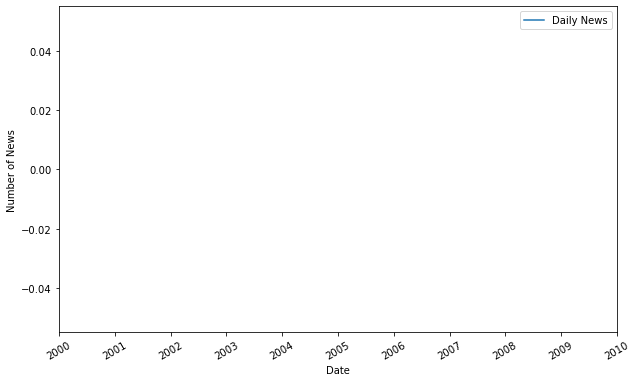

In [9]:
df_daily = daily_news()

In [10]:
publisher_list = top_publisher()
publisher_list

['뉴스1', '뉴시스', '이데일리', '파이낸셜뉴스', '아시아경제']

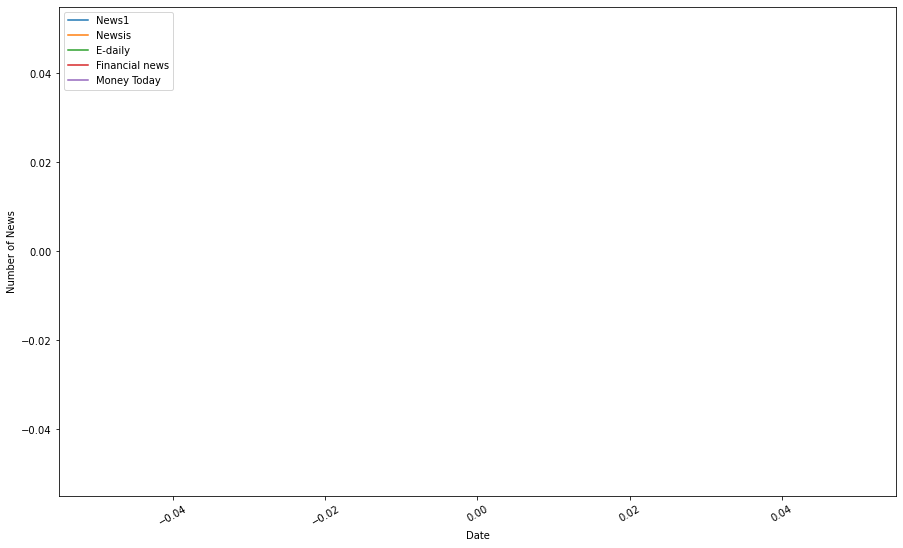

,뉴스1,뉴시스,이데일리,파이낸셜뉴스,아시아경제


In [11]:
news_trends_by_publisher(publisher_list)

In [12]:
keyword = ['전쟁', '인플레이션', '암호화폐']

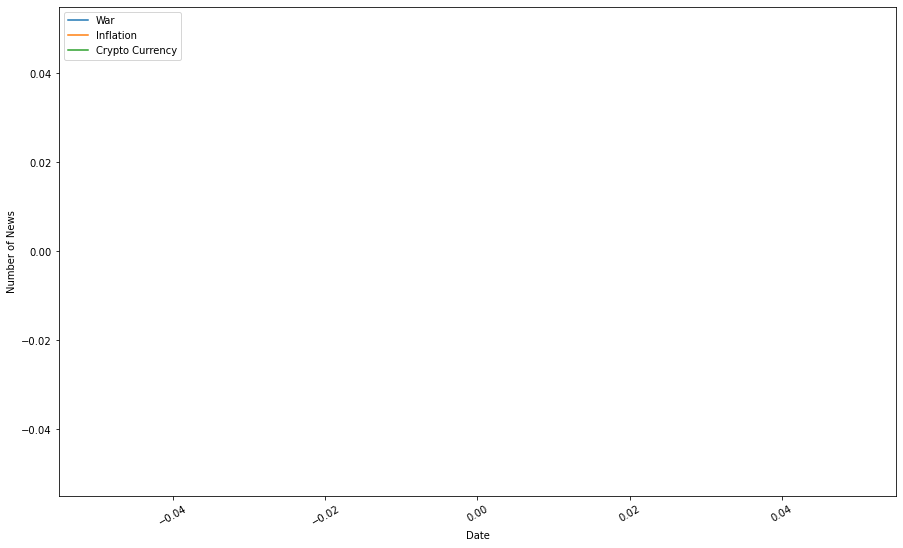

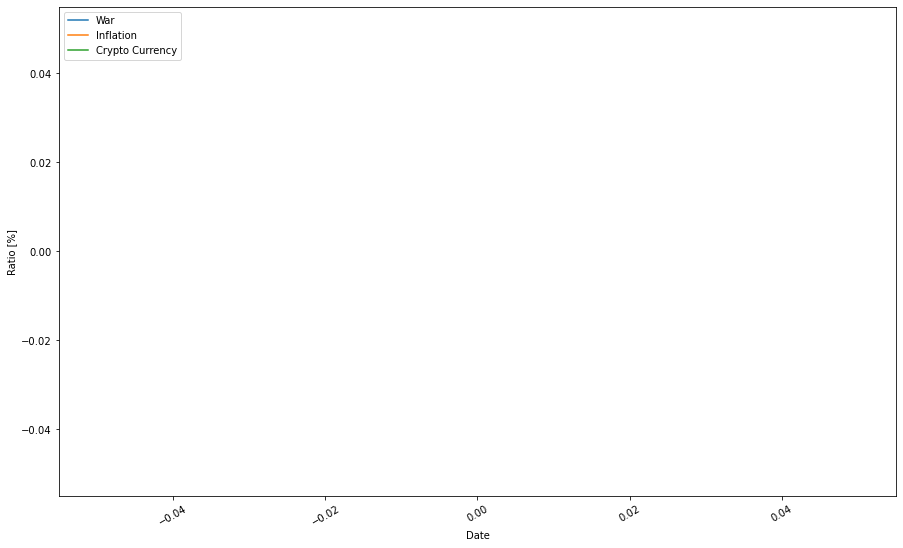

In [13]:
df_keyword = news_trends_by_keyword(keyword, df_daily)

In [18]:
may_titles = collect_titles()

Crawling date 1...
Crawling date 2...
Crawling date 3...
Crawling date 4...


KeyboardInterrupt: 

In [19]:
may_titles

[[],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 []]

In [15]:
with open('title_list_may.txt','w',encoding='UTF-8') as f:
    for dates in may_titles:
        num = str(may_titles.index(dates) + 1)
        f.write('\n'+ '['+num+']' +'\n\n')
        for titles in dates:
            f.write(titles+'\n')

        